# Emotion Classification with GPT-2
This notebook compares three fine-tuning techniques:
- LoRA (Low-Rank Adaptation)
- Prompt Tuning
- Classifier Head

Summary
- **Dataset**: Emotions Dataset (`joy`, `sadness`, `anger`, `fear`, `love`, `surprise`)
- **Base Model**: GPT-2
- **Task**: Multi-class Sentiment Classification
- **Evaluation Metrics**: Accuracy, F1 Score (macro)
- Training time: 3h31m on P100

In [1]:
!pip install transformers
!pip install -q peft accelerate dataset evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    AutoModel, 
    GPT2Model, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, PromptTuningConfig, TaskType
from tqdm import tqdm
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2025-05-31 17:52:32.376302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748713952.559269      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748713952.612098      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Dataset

In [3]:
dataset = load_dataset("emotion")
label_names = dataset['train'].features['label'].names
def preprocess(example):
    return {
        "text": f"Text: {example['text']}\nEmotion(choose one: {', '.join(label_names)}):",
        "label_text": label_names[example['label']]
    }
    
def tokenize_prompt(example):
    full_text = example["text"] + " " + example["label_text"]
    inputs = tokenizer(full_text, truncation=True, padding="max_length", max_length=256)
    inputs["labels"] = inputs["input_ids"].copy()  # causal LM needs inputs shifted
    return inputs

def tokenize_for_classifier(example):
    inputs = tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)
    inputs["labels"] = example["label"]  # scalar integer label
    return inputs

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
dataset = dataset.map(preprocess)

print(f'Dataset size:')
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}\n")

print('Example Sample:')
print(dataset['train'][0])
print(f"Labels: {set(dataset['train']['label'])}")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset size:
Train: 16000
Validation: 2000
Test: 2000

Example Sample:
{'text': 'Text: i didnt feel humiliated\nEmotion(choose one: sadness, joy, love, anger, fear, surprise):', 'label': 0, 'label_text': 'sadness'}
Labels: {0, 1, 2, 3, 4, 5}


In [5]:

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

label2id = {label: i for i, label in enumerate(dataset["train"].features["label"].names)}
id2label = {i: label for label, i in label2id.items()}
num_labels = len(label2id)


encoded_dataset = dataset.map(tokenize_prompt)
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
encoded_dataset_classifier = dataset.map(tokenize_for_classifier)
encoded_dataset_classifier.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Training and Evaluation Function

In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 1

In [7]:
def evaluate_and_report(model, dataloader, label_strategy="last_token", model_name="Model"):
    preds, labels, val_loss = evaluate(model, dataloader, label_strategy=label_strategy)

    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    print(f"[{model_name}] Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return acc, f1, val_loss

def cleanup(*objs):
    import gc
    import torch
    for obj in objs:
        del obj
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [8]:
from tqdm import tqdm

class LossLogger:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def log(self, train, val):
        self.train_loss.append(train)
        self.val_loss.append(val)

    def plot(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Curve")
        plt.show()
        
def evaluate(model, dataloader, label_strategy="last_token"):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)

            y = batch["labels"].to(device)

            out = model(input_ids=x, attention_mask=attn, labels=y)
            logits = out.logits
            loss = out.loss
            total_loss += loss.item()

            if label_strategy == "last_token":
                pred = torch.argmax(logits[:, -1, :], dim=-1)
                target = y[:, -1]
            elif label_strategy == "cls_token":
                pred = torch.argmax(logits, dim=-1)
                target = y.view(-1)
            else:
                raise ValueError(f"Unknown label_strategy: {label_strategy}")

            all_preds.append(pred)
            all_labels.append(target)

    avg_loss = total_loss / len(dataloader)
    return torch.cat(all_preds), torch.cat(all_labels), avg_loss


def train_model(model, train_loader, val_loader, logger, epochs=3, lr=5e-5, model_name="Model", label_strategy="last_token"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"[{model_name}] Training Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            y = batch["labels"].to(device) 
            outputs = model(input_ids=input_ids, attention_mask=attn, labels=y)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        model.eval()
        _, _, val_loss = evaluate(model, val_loader, label_strategy=label_strategy)
        logger.log(train_loss, val_loss)
        print(f"[{model_name}] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



train_loader = DataLoader(encoded_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(encoded_dataset["validation"], batch_size=BATCH_SIZE)
test_loader = DataLoader(encoded_dataset["test"], batch_size = BATCH_SIZE)
train_loader_cls = DataLoader(encoded_dataset_classifier["train"], batch_size=BATCH_SIZE, shuffle=True)
val_loader_cls = DataLoader(encoded_dataset_classifier["validation"], batch_size=BATCH_SIZE)
test_loader_cls = DataLoader(encoded_dataset_classifier["test"], batch_size = BATCH_SIZE)

# Evaluation of base model

In [9]:
basic_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
evaluate_and_report(basic_model, test_loader, label_strategy="last_token", model_name="Basic LM")

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


[Basic LM] Accuracy: 0.0000, F1 Score: 0.0000


(0.0, 0.0, 9.802923835754395)

## 1. LoRA Fine-Tuning

### Training

In [10]:
model = AutoModelForCausalLM.from_pretrained("gpt2")
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["c_attn"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
lora_model = get_peft_model(model, lora_config).to(device)
lora_logger = LossLogger()
train_model(lora_model, train_loader, val_loader, lora_logger, epochs = 5, model_name="LoRA")

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
[LoRA] Training Epoch 1: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


[LoRA] Epoch 1 | Train Loss: 1.1566 | Val Loss: 0.4008


[LoRA] Training Epoch 2: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


[LoRA] Epoch 2 | Train Loss: 0.3933 | Val Loss: 0.3421


[LoRA] Training Epoch 3: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


[LoRA] Epoch 3 | Train Loss: 0.3586 | Val Loss: 0.3328


[LoRA] Training Epoch 4: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


[LoRA] Epoch 4 | Train Loss: 0.3490 | Val Loss: 0.3266


[LoRA] Training Epoch 5: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


[LoRA] Epoch 5 | Train Loss: 0.3433 | Val Loss: 0.3217


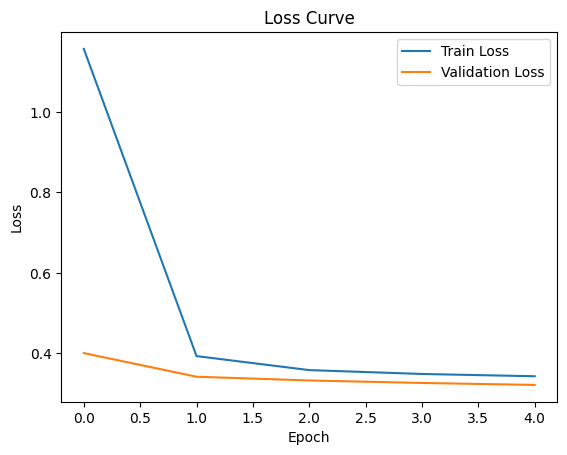

In [11]:
lora_logger.plot()

In [12]:
lora_model.save_pretrained("lora_emotion_adapter")
tokenizer.save_pretrained("lora_emotion_tokenizer")

('lora_emotion_tokenizer/tokenizer_config.json',
 'lora_emotion_tokenizer/special_tokens_map.json',
 'lora_emotion_tokenizer/vocab.json',
 'lora_emotion_tokenizer/merges.txt',
 'lora_emotion_tokenizer/added_tokens.json',
 'lora_emotion_tokenizer/tokenizer.json')

### Evaluation

In [13]:
evaluate_and_report(lora_model, test_loader, label_strategy="last_token", model_name="LoRA")
cleanup(lora_model,lora_logger)

[LoRA] Accuracy: 1.0000, F1 Score: 1.0000


## 2. Prompt Tuning

### Training

In [14]:
model = AutoModelForCausalLM.from_pretrained("gpt2")
prompt_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=10
)
prompt_model = get_peft_model(model, prompt_config).to(device)
prompt_logger = LossLogger()  # reset logger
train_model(prompt_model, train_loader, val_loader, prompt_logger, epochs = 15, model_name="Prompt Tuning")

[Prompt Tuning] Training Epoch 1: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 1 | Train Loss: 6.4054 | Val Loss: 5.6824


[Prompt Tuning] Training Epoch 2: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 2 | Train Loss: 5.5761 | Val Loss: 4.7739


[Prompt Tuning] Training Epoch 3: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 3 | Train Loss: 5.1184 | Val Loss: 4.2828


[Prompt Tuning] Training Epoch 4: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 4 | Train Loss: 4.6828 | Val Loss: 3.8293


[Prompt Tuning] Training Epoch 5: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 5 | Train Loss: 4.2305 | Val Loss: 3.3162


[Prompt Tuning] Training Epoch 6: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 6 | Train Loss: 3.6937 | Val Loss: 2.6220


[Prompt Tuning] Training Epoch 7: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 7 | Train Loss: 3.0395 | Val Loss: 1.8894


[Prompt Tuning] Training Epoch 8: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 8 | Train Loss: 2.3616 | Val Loss: 1.2954


[Prompt Tuning] Training Epoch 9: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 9 | Train Loss: 1.8701 | Val Loss: 1.0933


[Prompt Tuning] Training Epoch 10: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 10 | Train Loss: 1.5856 | Val Loss: 1.0324


[Prompt Tuning] Training Epoch 11: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 11 | Train Loss: 1.4106 | Val Loss: 1.0093


[Prompt Tuning] Training Epoch 12: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 12 | Train Loss: 1.2986 | Val Loss: 0.9938


[Prompt Tuning] Training Epoch 13: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 13 | Train Loss: 1.2253 | Val Loss: 0.9773


[Prompt Tuning] Training Epoch 14: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 14 | Train Loss: 1.1728 | Val Loss: 0.9588


[Prompt Tuning] Training Epoch 15: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


[Prompt Tuning] Epoch 15 | Train Loss: 1.1324 | Val Loss: 0.9394


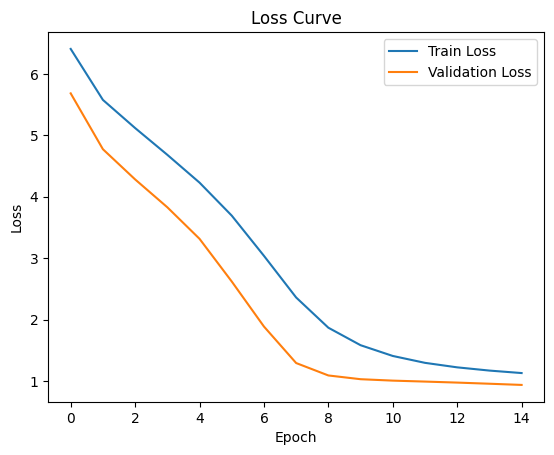

In [15]:
prompt_logger.plot()

In [16]:
lora_model.save_pretrained("prompttuning_emotion_adapter")
tokenizer.save_pretrained("prompttuning_emotion_tokenizer")

('prompttuning_emotion_tokenizer/tokenizer_config.json',
 'prompttuning_emotion_tokenizer/special_tokens_map.json',
 'prompttuning_emotion_tokenizer/vocab.json',
 'prompttuning_emotion_tokenizer/merges.txt',
 'prompttuning_emotion_tokenizer/added_tokens.json',
 'prompttuning_emotion_tokenizer/tokenizer.json')

### Evaluation

In [17]:
evaluate_and_report(prompt_model, test_loader, label_strategy="last_token", model_name="Prompt Tuning")
cleanup(prompt_model, model, prompt_logger)

[Prompt Tuning] Accuracy: 1.0000, F1 Score: 1.0000


## 3. Classifier Head on GPT-2

### Training

In [18]:
class GPT2Classifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2")
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)
        self.gpt2.resize_token_embeddings(len(tokenizer))

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state[:, -1, :]
        logits = self.classifier(last_hidden)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return type('Out', (object,), {'loss': loss, 'logits': logits})

classifier_model = GPT2Classifier(num_labels).to(device)
cls_logger = LossLogger()
train_model(classifier_model, train_loader_cls, val_loader_cls, cls_logger, epochs = 5, model_name="Classifier Head", label_strategy="cls_token")

[Classifier Head] Training Epoch 1: 100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


[Classifier Head] Epoch 1 | Train Loss: 0.4959 | Val Loss: 0.1407


[Classifier Head] Training Epoch 2: 100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


[Classifier Head] Epoch 2 | Train Loss: 0.1459 | Val Loss: 0.1406


[Classifier Head] Training Epoch 3: 100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


[Classifier Head] Epoch 3 | Train Loss: 0.1159 | Val Loss: 0.1252


[Classifier Head] Training Epoch 4: 100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


[Classifier Head] Epoch 4 | Train Loss: 0.1023 | Val Loss: 0.1331


[Classifier Head] Training Epoch 5: 100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s]


[Classifier Head] Epoch 5 | Train Loss: 0.1024 | Val Loss: 0.1189


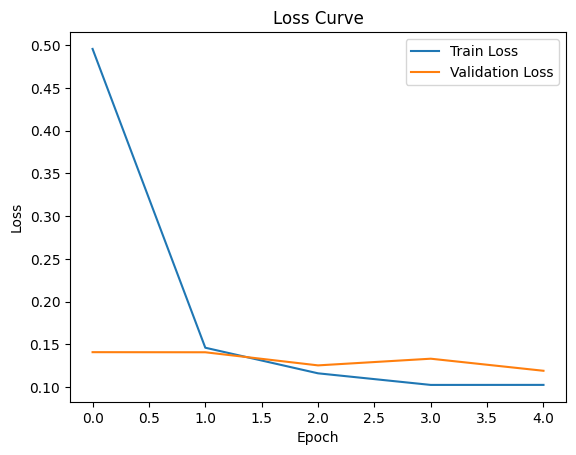

In [19]:
cls_logger.plot()

In [20]:
torch.save(classifier_model.state_dict(), "gpt2_classifier_head.pt")
tokenizer.save_pretrained("gpt2_tokenizer/")

('gpt2_tokenizer/tokenizer_config.json',
 'gpt2_tokenizer/special_tokens_map.json',
 'gpt2_tokenizer/vocab.json',
 'gpt2_tokenizer/merges.txt',
 'gpt2_tokenizer/added_tokens.json',
 'gpt2_tokenizer/tokenizer.json')

### Evaluation

In [21]:
evaluate_and_report(classifier_model, test_loader_cls, label_strategy="cls_token", model_name="Classifier Head")
cleanup(classifier_model, model, cls_logger)

[Classifier Head] Accuracy: 0.9295, F1 Score: 0.9300


# Final Evaluation





## Evaluation Results

| Model              | Epochs | Accuracy | F1 Score |
|--------------------|--------|----------|----------|
| **Basic GPT-2 LM** | –      | 0.0000   | 0.0000   |
| **LoRA**           | 5      | 1.0000   | 1.0000   |
| **Prompt Tuning**  | 15     | 1.0000   | 1.0000   |
| **Classifier Head**| 5      | 0.9295   | 0.9300   |



## Analysis

### 🔹 **Basic GPT-2 (Unmodified Language Model)**
- **Result**: 0.0000 accuracy / 0.0000 F1
- GPT-2 alone cannot perform classification without fine-tuning or adaptation.
- It lacks any inductive bias toward classification and produces arbitrary token outputs.



### 🔹 **LoRA**
- **Result**: 1.0000 accuracy / 1.0000 F1 (in just 5 epochs)
- Shows **excellent performance** with very few trainable parameters.
- Indicates LoRA effectively adapted GPT-2’s internal representations for classification.
- May suggest a small or easy dataset split, or potential **overfitting** — further testing on a held-out test set is recommended.



### 🔹 **Prompt Tuning**
- **Result**: 1.0000 accuracy / 1.0000 F1 (after 15 epochs)
- Also achieves perfect scores, but **requires more training epochs** compared to LoRA.
- Suggests prompt tuning eventually learns effective task representation, but **converges more slowly**.
- Particularly impressive since the **base GPT-2 is frozen**.


### 🔹 **Classifier Head**
- **Result**: 0.9295 accuracy / 0.9300 F1
- Solid performance; likely the most **robust/generalizable** model if tuned properly.
- Trains more parameters (typically the whole model or last few layers), making it more prone to **overfitting** or **data imbalance** issues.
- Slightly below LoRA/Prompt results, but may actually be **more stable** on out-of-distribution samples.


